In [ ]:
#This set of code contains solutions of question no 2 and question no. 3 respectively  
 2. RDKit 
-	Task: Write a script using RDKit to convert a dataset of molecular structures from SMILES to 3D conformations.
-	Requirements: Your script should handle errors gracefully and optimize the geometry of the generated conformers.
-	Deliverable: A Python script and a short report summarizing the methodologies used.


3. Density Functional Theory (DFT)
-	Task: Use Python to perform a basic DFT calculation on a simple molecule (e.g., water) and analyze its electronic structure.
-	Requirements: Include explanations for each step and parameter in your code.
-	Deliverable: Python script and a document explaining your findings and the implications of the results.



In [1]:
#pip install 'numpy ==1.22.0'

In [2]:
#pip list

In [9]:
import os
import rdkit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from rdkit import Chem  # To extract information of the molecules
from rdkit.Chem import Draw  # To draw the molecules
from mordred import Calculator, descriptors  # To calculate descriptors
from molml.features import CoulombMatrix  # To calculate the coulomb matrix
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau


In [2]:
#pip install mordred


In [4]:
#pip install molml

In [6]:
#pip install tensorflow

In [13]:
pwd

'C:\\Users\\ASUS\\Desktop\\anaconda\\quantumProject'

In [21]:

# Checking the number of XYZ files
directory = 'C:\\Users\\ASUS\\Desktop\\anaconda\\quantumProject\\dataset'
len(os.listdir(directory))

13193

In [23]:
def read_xyz(path):
    """
    Reads the xyz files in the directory on 'path'
    Input
    path: the path to the folder to be read
    
    Output
    atoms: list with the characters representing the atoms of a molecule
    coordinates: list with the cartesian coordinates of each atom
    smile: list with the SMILE representation of a molecule
    prop: list with the scalar properties
    """
    atoms = []
    coordinates = []

    with open(path, 'r') as file:
        lines = file.readlines()
        n_atoms = int(lines[0])  # the number of atoms
        smile = lines[n_atoms + 3].split()[0]  # smiles string
        prop = lines[1].split()[2:]  # scalar properties
        
        # to retrieve each atmos and its cartesian coordenates
        for atom in lines[2:n_atoms + 2]:
            line = atom.split()
            # which atom
            atoms.append(line[0])

            # its coordinate
            # Some properties have '*^' indicading exponentiation 
            try:
                coordinates.append(
                    (float(line[1]),
                     float(line[2]),
                     float(line[3]))
                    )
            except:
                coordinates.append(
                    (float(line[1].replace('*^', 'e')),
                     float(line[2].replace('*^', 'e')),
                     float(line[3].replace('*^', 'e')))
                    )
                    
    return atoms, coordinates, smile, prop

In [25]:
# Reads the xyz files and return the properties, smiles and coordinates
data = []
smiles = []
properties = []
for file in os.listdir(directory):
    path = os.path.join(directory, file)
    atoms, coordinates, smile, prop = read_xyz(path)
    data.append((atoms, coordinates)) # A tuple with the atoms and its coordinates 
    smiles.append(smile) # The SMILES representation
    properties.append(prop) # The molecules properties

In [27]:
properties_names = ['A', 'B', 'C', 'mu', 'alfa', 'homo', 'lumo', 'gap', 'R²', 'zpve', 'U0', 'U', 'H', 'G', 'Cv']
df = pd.DataFrame(properties, columns = properties_names).astype('float32')
df['smiles'] = smiles
df.head()

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,smiles
0,2.37902,1.28942,0.90648,5.0291,77.910004,-0.2406,0.0008,0.2414,1319.646606,0.169395,-440.289520,-440.279724,-440.278778,-440.324982,35.090000,CC(=O)N1CC1CCO
1,3.02289,0.81121,0.72699,2.5419,88.169998,-0.2397,-0.0097,0.2300,1703.617188,0.203713,-388.313843,-388.303192,-388.302246,-388.350372,38.278000,CCCC1CC1C(C)=O
2,3.05343,0.82158,0.73449,3.3028,84.379997,-0.2436,0.0295,0.2730,1654.381226,0.193481,-404.384583,-404.374146,-404.373199,-404.420807,37.931000,CCCC1CC1C(N)=O
3,2.66042,1.00934,0.80516,3.1054,84.489998,-0.2409,0.0133,0.2542,1523.455322,0.191992,-404.363739,-404.353149,-404.352203,-404.400330,37.382999,CCCC1CN1C(C)=O
4,2.70600,1.03570,0.82177,3.1807,80.519997,-0.2430,0.0423,0.2853,1467.506348,0.182197,-420.429260,-420.419281,-420.418335,-420.464600,36.589001,CCCC1CN1C(N)=O


In [29]:
# Reading each molecule by its SMILES string
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

In [31]:
# Checking if there are None values
df['mol'].isnull().sum()


0

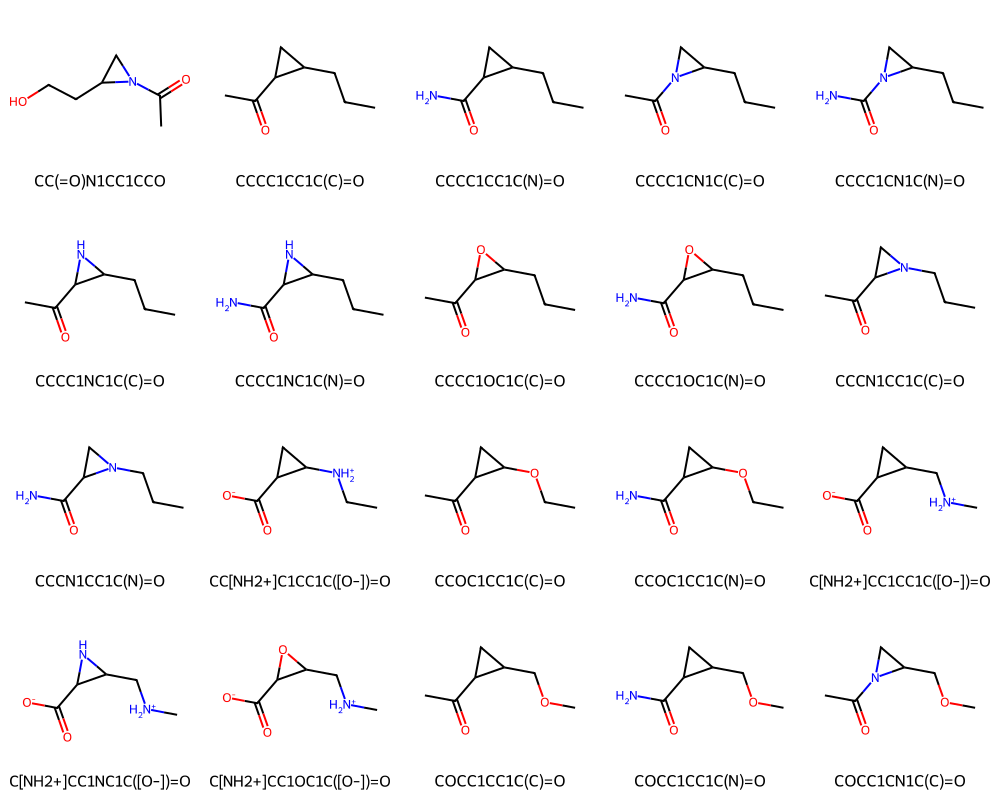

In [33]:
# Reads and prints the 20 first molecules
mol = df['mol'][:20]

Draw.MolsToGridImage(mol, molsPerRow=5, useSVG=True, legends=list(df['smiles'][:20].values))


In [35]:
df['mol'][0].GetNumAtoms()


9

In [37]:
data[0]


(['C',
  'C',
  'O',
  'N',
  'C',
  'C',
  'C',
  'C',
  'O',
  'H',
  'H',
  'H',
  'H',
  'H',
  'H',
  'H',
  'H',
  'H',
  'H',
  'H'],
 [(0.1295625682, 1.0176836307, -0.4523435738),
  (-0.0207934987, -0.4792739908, -0.2761486954),
  (0.8476090726, -1.267697282, -0.6129441574),
  (-1.1678691878, -0.8724118563, 0.3626719725),
  (-2.5516501615, -0.5148689284, 0.2007309744),
  (-2.0975121028, -1.9574092659, 0.1709524671),
  (-2.1825433661, -2.7789089387, -1.1010402632),
  (-1.2578484325, -4.0114111447, -1.1389340345),
  (0.0503166601, -3.7477321057, -1.5663376888),
  (1.1850277248, 1.2554619161, -0.58441932),
  (-0.411246451, 1.3357781763, -1.3511352291),
  (-0.2819232562, 1.5671986722, 0.3974967489),
  (-3.0590516805, -0.1162605127, 1.0762862617),
  (-2.8554652699, -0.0742166829, -0.747185491),
  (-2.2723490176, -2.5349558771, 1.0793869645),
  (-3.2233386765, -3.1212768439, -1.1784497527),
  (-1.9796994972, -2.156251825, -1.9800405966),
  (-1.2853494814, -4.5019389721, -0.1476387225

In [39]:
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))

In [41]:
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

In [43]:
df.head()


,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,smiles,mol,num_of_atoms,num_of_heavy_atoms
0,2.37902,1.28942,0.90648,5.0291,77.910004,-0.2406,0.0008,0.2414,1319.646606,0.169395,-440.289520,-440.279724,-440.278778,-440.324982,35.090000,CC(=O)N1CC1CCO,<rdkit.Chem.rdchem.Mol object at 0x000002640F6...,20,9
1,3.02289,0.81121,0.72699,2.5419,88.169998,-0.2397,-0.0097,0.2300,1703.617188,0.203713,-388.313843,-388.303192,-388.302246,-388.350372,38.278000,CCCC1CC1C(C)=O,<rdkit.Chem.rdchem.Mol object at 0x000002640F7...,23,9
2,3.05343,0.82158,0.73449,3.3028,84.379997,-0.2436,0.0295,0.2730,1654.381226,0.193481,-404.384583,-404.374146,-404.373199,-404.420807,37.931000,CCCC1CC1C(N)=O,<rdkit.Chem.rdchem.Mol object at 0x000002640F7...,22,9
3,2.66042,1.00934,0.80516,3.1054,84.489998,-0.2409,0.0133,0.2542,1523.455322,0.191992,-404.363739,-404.353149,-404.352203,-404.400330,37.382999,CCCC1CN1C(C)=O,<rdkit.Chem.rdchem.Mol object at 0x000002640F7...,22,9
4,2.70600,1.03570,0.82177,3.1807,80.519997,-0.2430,0.0423,0.2853,1467.506348,0.182197,-420.429260,-420.419281,-420.418335,-420.464600,36.589001,CCCC1CN1C(N)=O,<rdkit.Chem.rdchem.Mol object at 0x000002640F7...,21,9


In [45]:
def canonize(mol):
    return Chem.MolToSmiles(Chem.MolFromSmiles(mol), isomericSmiles=True, canonical=True)

canon_smile = []
for molecule in smiles:
    canon_smile.append(canonize(molecule))
    
df['canon_smiles'] = canon_smile

In [47]:
df.head()

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,smiles,mol,num_of_atoms,num_of_heavy_atoms,canon_smiles
0,2.37902,1.28942,0.90648,5.0291,77.910004,-0.2406,0.0008,0.2414,1319.646606,0.169395,-440.289520,-440.279724,-440.278778,-440.324982,35.090000,CC(=O)N1CC1CCO,<rdkit.Chem.rdchem.Mol object at 0x000002640F6...,20,9,CC(=O)N1CC1CCO
1,3.02289,0.81121,0.72699,2.5419,88.169998,-0.2397,-0.0097,0.2300,1703.617188,0.203713,-388.313843,-388.303192,-388.302246,-388.350372,38.278000,CCCC1CC1C(C)=O,<rdkit.Chem.rdchem.Mol object at 0x000002640F7...,23,9,CCCC1CC1C(C)=O
2,3.05343,0.82158,0.73449,3.3028,84.379997,-0.2436,0.0295,0.2730,1654.381226,0.193481,-404.384583,-404.374146,-404.373199,-404.420807,37.931000,CCCC1CC1C(N)=O,<rdkit.Chem.rdchem.Mol object at 0x000002640F7...,22,9,CCCC1CC1C(N)=O
3,2.66042,1.00934,0.80516,3.1054,84.489998,-0.2409,0.0133,0.2542,1523.455322,0.191992,-404.363739,-404.353149,-404.352203,-404.400330,37.382999,CCCC1CN1C(C)=O,<rdkit.Chem.rdchem.Mol object at 0x000002640F7...,22,9,CCCC1CN1C(C)=O
4,2.70600,1.03570,0.82177,3.1807,80.519997,-0.2430,0.0423,0.2853,1467.506348,0.182197,-420.429260,-420.419281,-420.418335,-420.464600,36.589001,CCCC1CN1C(N)=O,<rdkit.Chem.rdchem.Mol object at 0x000002640F7...,21,9,CCCC1CN1C(N)=O


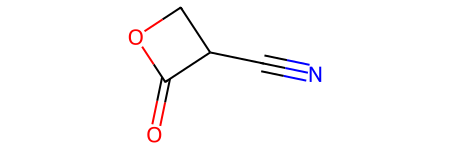

In [49]:
Chem.MolFromSmiles('O=C1OCC1C#N')


In [51]:
df['canon_smiles'][df['canon_smiles'].duplicated()]

4419            Cc1c(O)cnnc1N
4422            Cc1c(O)cnnc1O
9028            Nc1c(O)cnnc1O
9422            Nc1nncc(O)c1O
11229    O=[N+]([O-])c1cnccn1
12018          O=Cc1cnc(F)cn1
12031          C#Cc1cnc(F)cn1
12032          N#Cc1cnc(F)cn1
12346           CCc1cnc(F)cn1
12353           CNc1cnc(F)cn1
12360           COc1cnc(F)cn1
12367           OCc1cnc(F)cn1
12455           Cc1c(F)cnnc1N
12463           Cc1c(F)cnnc1O
12464           Cc1c(O)cnnc1F
12465           Cc1c(F)cnnc1F
12633           Nc1c(F)cnnc1O
12634           Nc1c(O)cnnc1F
12635           Nc1c(F)cnnc1F
12671           Nc1nncc(F)c1N
12672           Nc1nncc(O)c1F
12673           Nc1nncc(F)c1O
12674           Nc1nncc(F)c1F
Name: canon_smiles, dtype: object

In [53]:
df[df['canon_smiles'] == 'COc1cnccn1']


,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,smiles,mol,num_of_atoms,num_of_heavy_atoms,canon_smiles


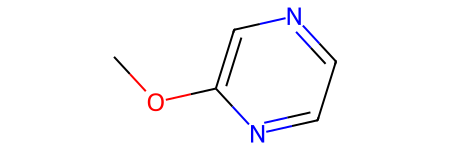

In [55]:
Chem.MolFromSmiles('COC1=CN=CC=N1')

In [57]:
ind = df.index[df['canon_smiles'].duplicated()]
df = df.drop(ind)

In [59]:
df['mol'] = df['canon_smiles'].apply(lambda x: Chem.MolFromSmiles(x))


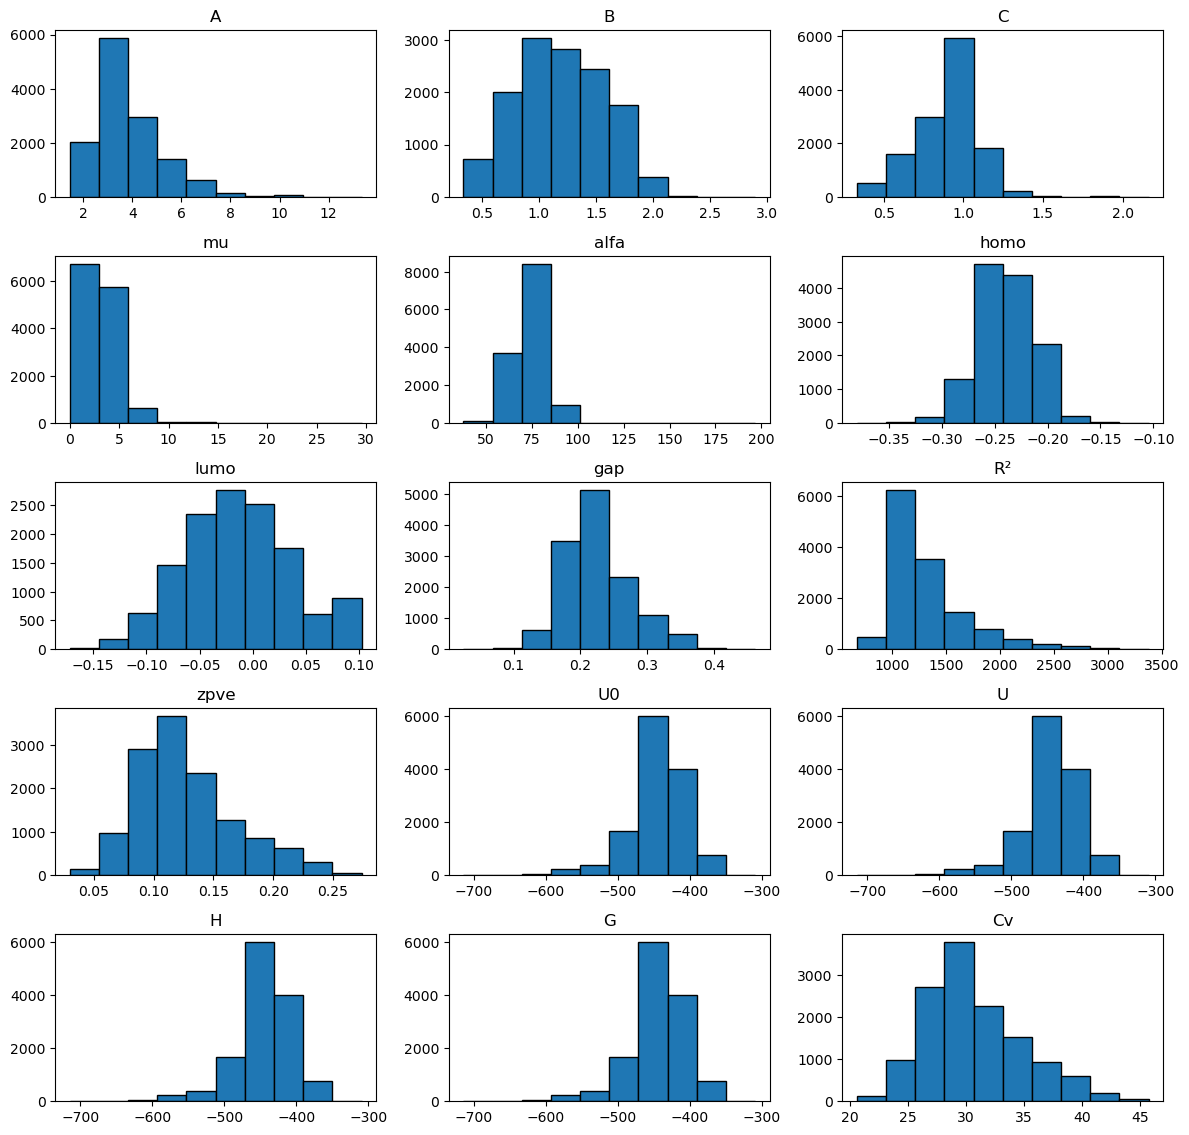

In [61]:
plt.figure(figsize=(12, 18))
plot_counter = 1
for prop in df.iloc[:,:15].columns:
    plt.subplot(int(np.ceil(len(df.iloc[:,:15].columns)/2)), 3, plot_counter)
    plt.hist(df.iloc[:,:15][prop], edgecolor='k')
    plt.title(prop)
    plot_counter += 1
plt.tight_layout()
plt.show()

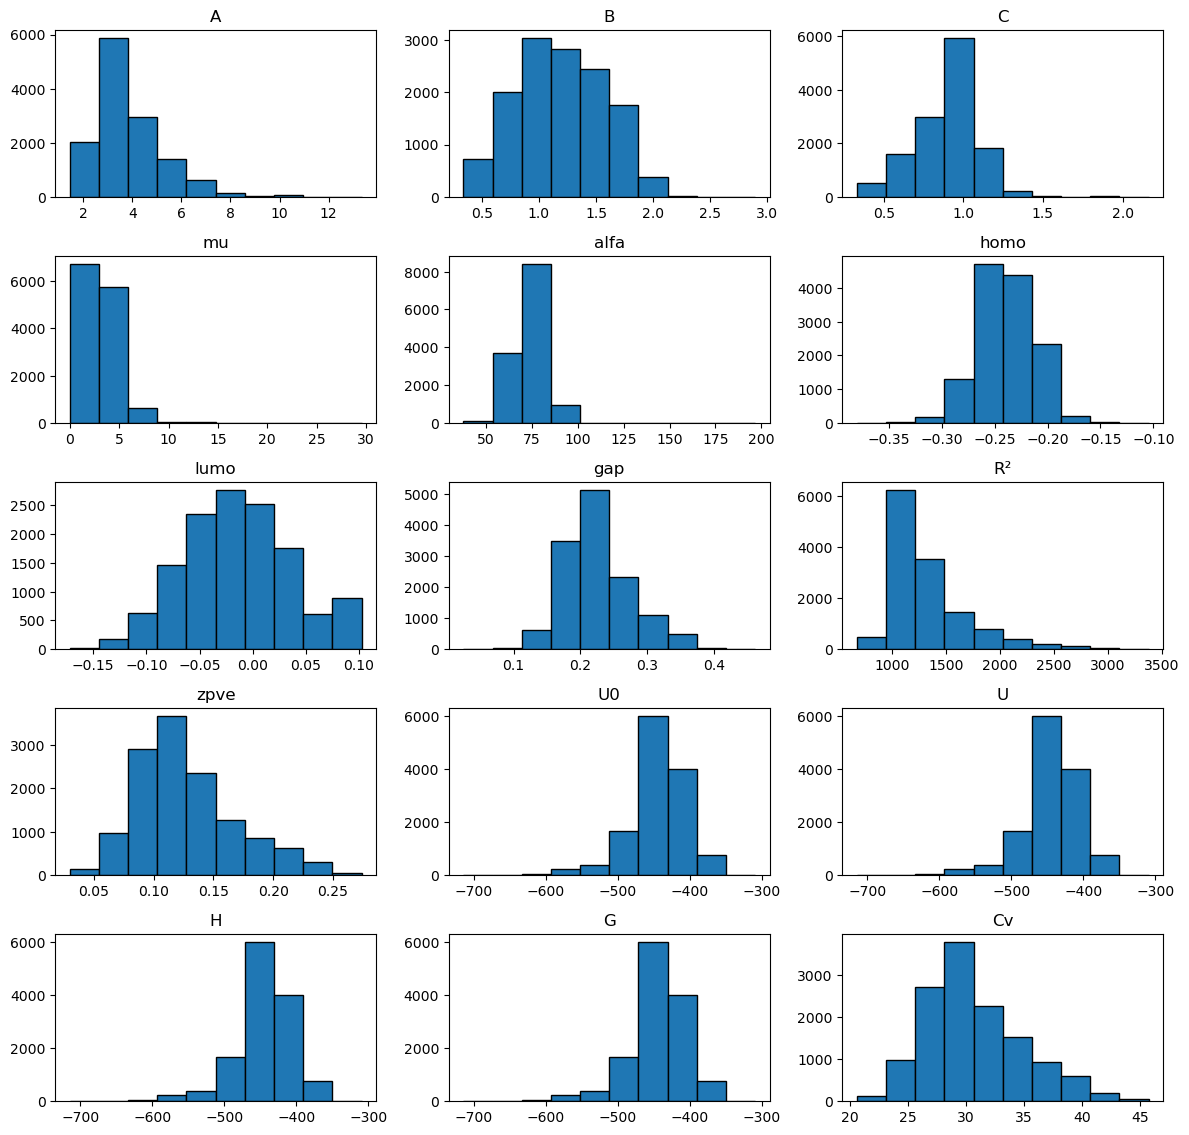

In [63]:
plt.figure(figsize=(12, 18))
plot_counter = 1
for prop in df.iloc[:,:15].columns:
    plt.subplot(int(np.ceil(len(df.iloc[:,:15].columns)/2)), 3, plot_counter)
    plt.hist(df.iloc[:,:15][prop], edgecolor='k')
    plt.title(prop)
    plot_counter += 1
plt.tight_layout()
plt.show()


In [65]:
# Saving the final dataframe
df.to_csv('qm9.csv')

In [67]:
df.shape

(13170, 20)

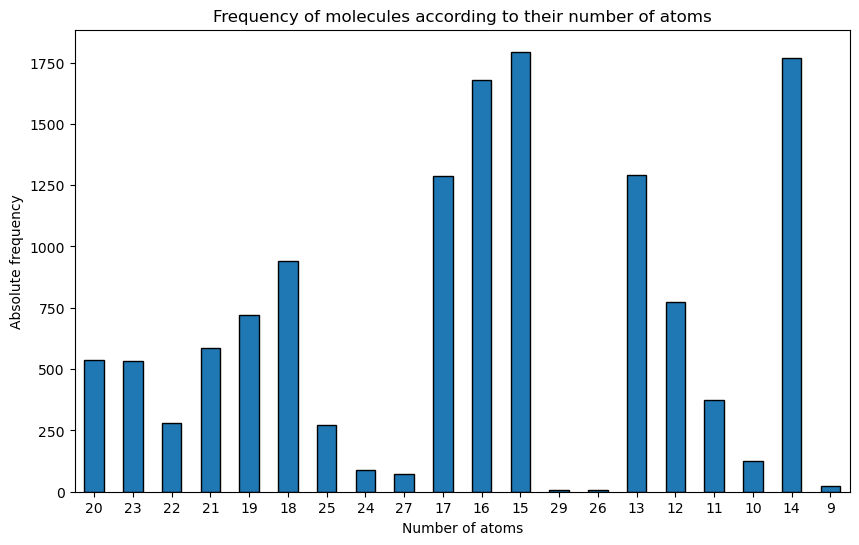

In [69]:
df['num_of_atoms'].value_counts(sort=False).plot.bar(figsize=(10,6), 
                                                     title="Frequency of molecules according to their number of atoms", 
                                                     xlabel='Number of atoms',
                                                     ylabel='Absolute frequency',
                                                     rot=0,
                                                     edgecolor='k')
plt.show()


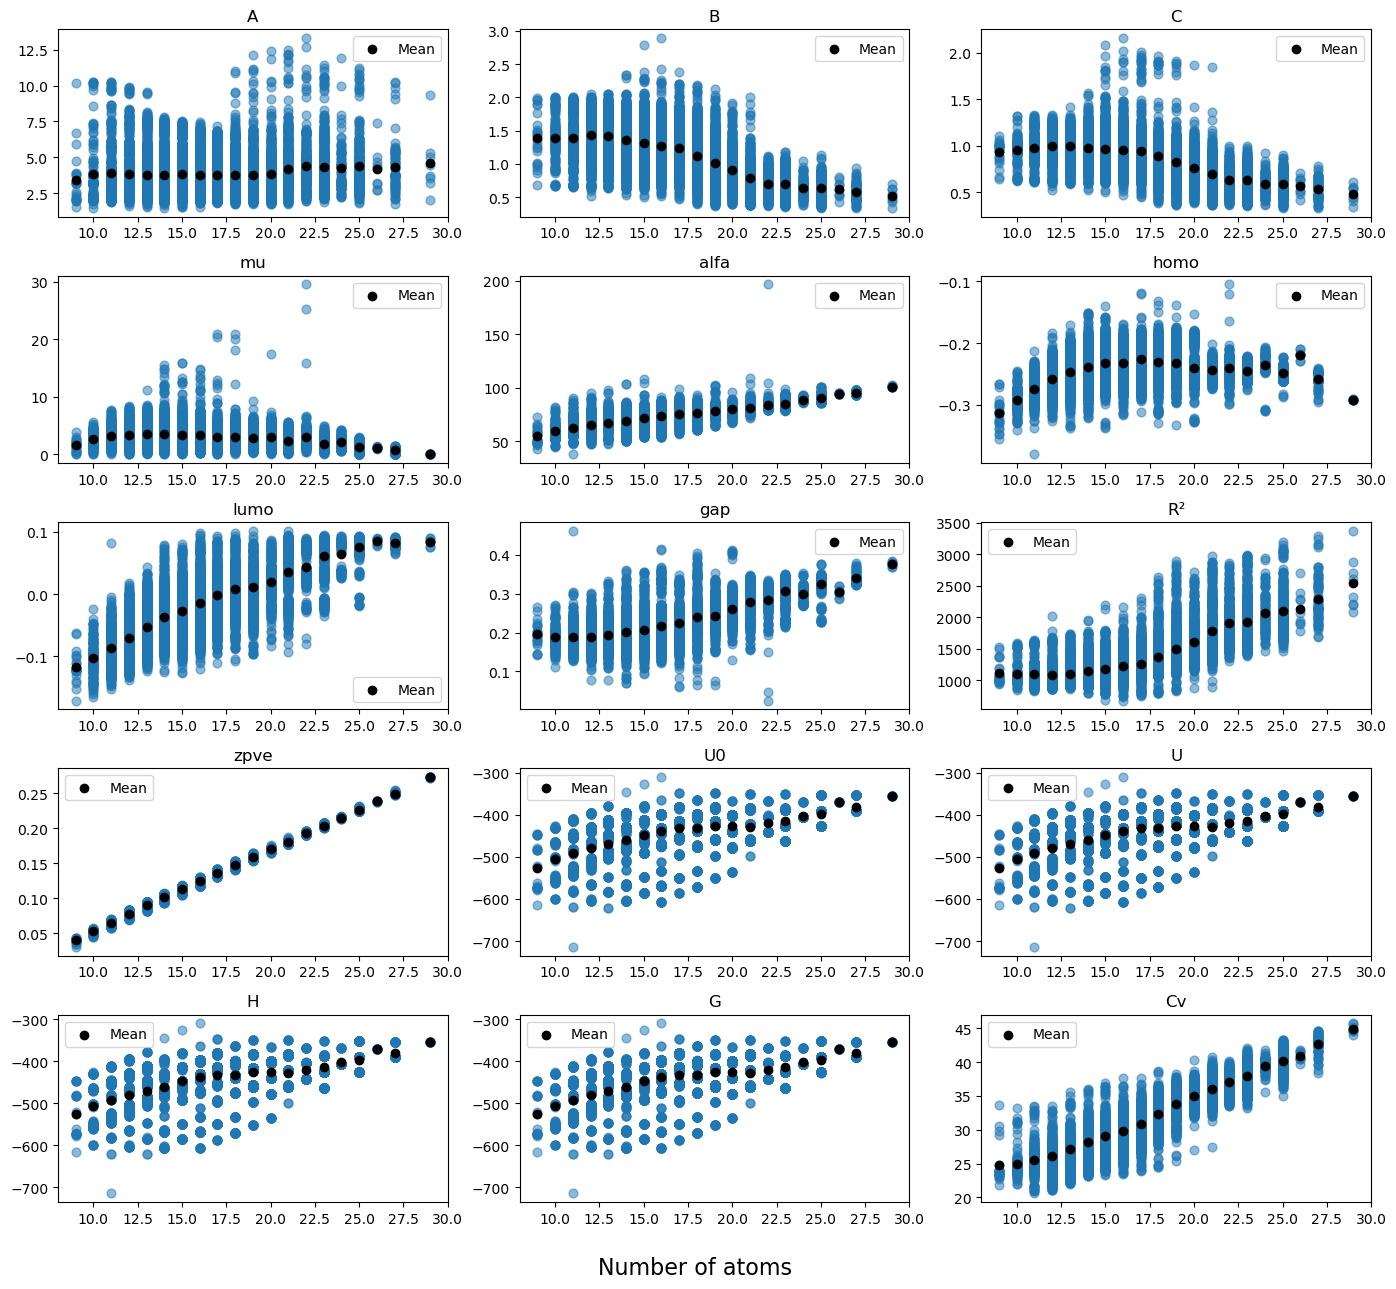

In [71]:
plt.figure(figsize=(14,20))
plot_counter = 1
for prop in df.iloc[:,:15].columns:
    plt.subplot(int(np.ceil(len(df.iloc[:,:15].columns)/2)), 3, plot_counter)
    plt.scatter(df['num_of_atoms'], df[prop], s=40, alpha=0.5)
    
    for atom in np.unique(df['num_of_atoms']):
        plt.scatter(atom, df[prop][df['num_of_atoms'] == atom].mean(), c='k', label='Mean')
        
    # Dictionaries can't have duplicated keys
    # This prevents repeated legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.title(prop)
    plot_counter = plot_counter + 1
    
plt.suptitle('Number of atoms', x=.5, y=0.35, ha='center', size=16) 
plt.tight_layout()
plt.show()

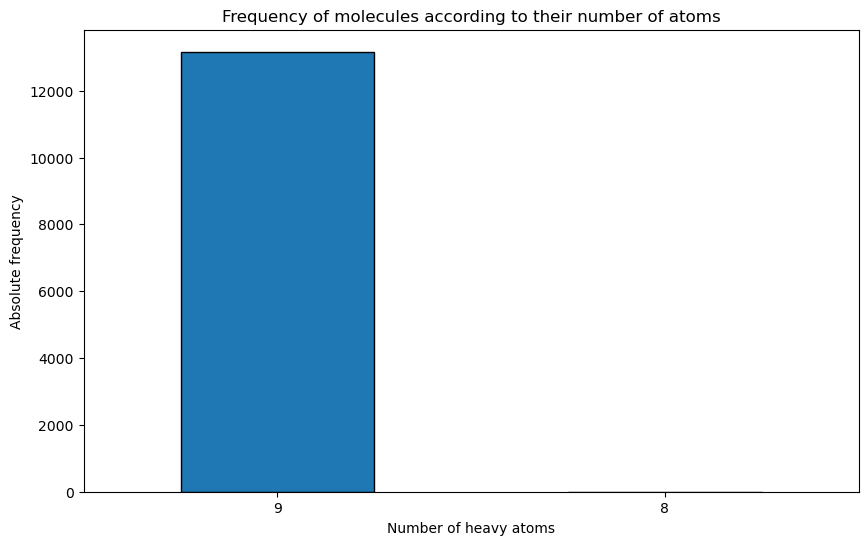

In [73]:
df['num_of_heavy_atoms'].value_counts(sort=False).plot.bar(figsize=(10,6), 
                                                     title="Frequency of molecules according to their number of atoms", 
                                                     xlabel='Number of heavy atoms',
                                                     ylabel='Absolute frequency',
                                                     rot=0,
                                                     edgecolor='k')
plt.show()

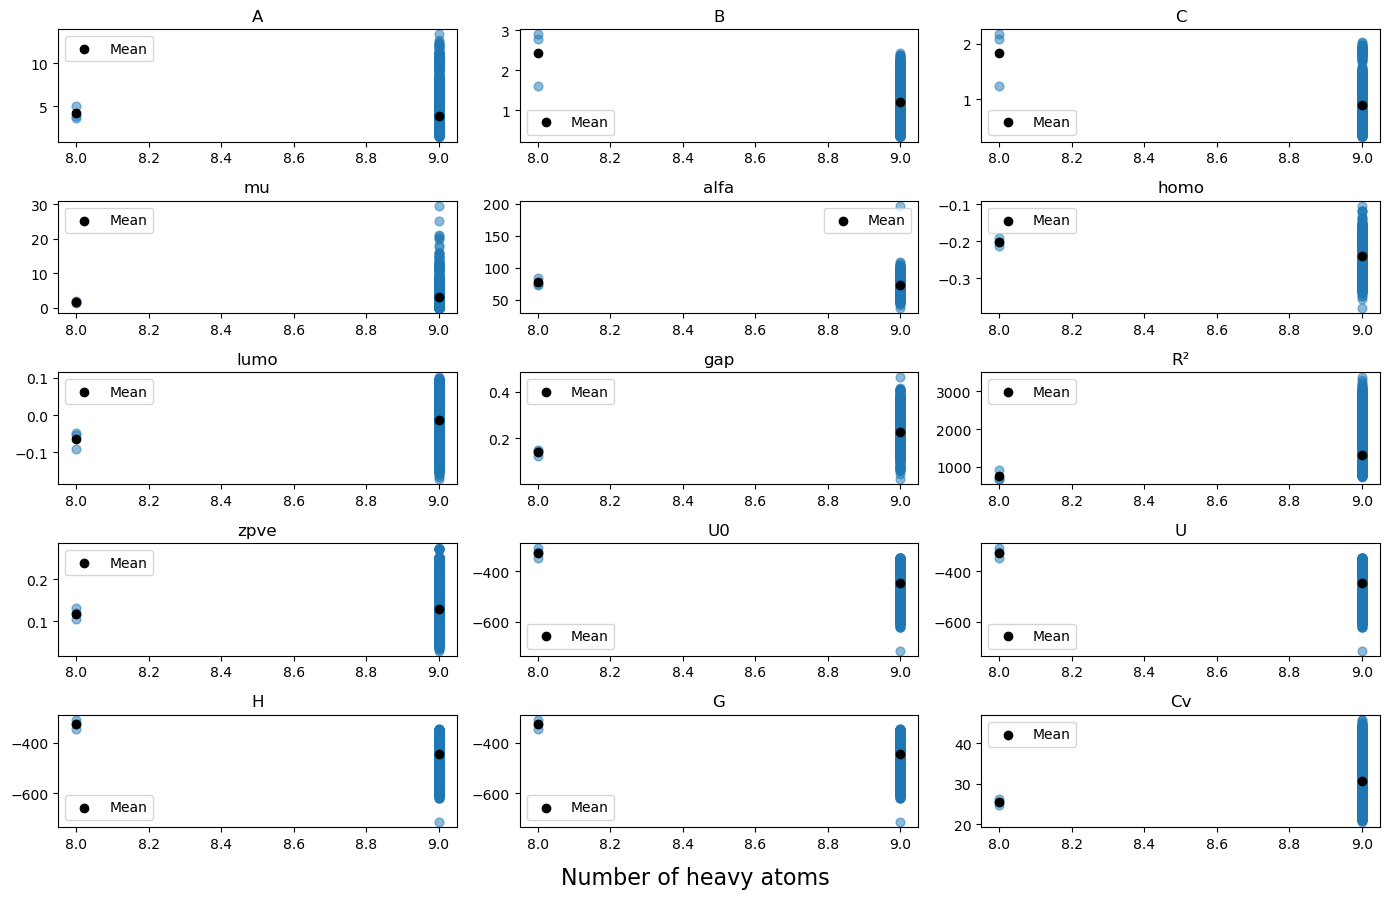

In [75]:
plt.figure(figsize=(14,14))
plot_counter = 1
for prop in df.iloc[:,:15].columns:
    plt.subplot(int(np.ceil(len(df.iloc[:,:15].columns)/2)), 3, plot_counter)
    plt.scatter(df['num_of_heavy_atoms'], df[prop], s=40, alpha=0.5)
    
    for atom in np.unique(df['num_of_heavy_atoms']):
        plt.scatter(atom, df[prop][df['num_of_heavy_atoms'] == atom].mean(), c='k', label='Mean')
        
    # Dictionaries can't have duplicated keys
    # This prevents repeated legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.title(prop)
    plot_counter = plot_counter + 1
    
plt.suptitle('Number of heavy atoms', x=.5, y=0.35, ha='center', size=16) 
plt.tight_layout()
plt.show()

In [77]:
# Using only the molecules with 19 atoms
calc = Calculator(descriptors, ignore_3D=True)
df_desc = calc.pandas(df['mol'][df['num_of_atoms']==19])

# Saving the resulting file 
df_desc.to_csv('descriptors.csv')


100%|██████████| 722/722 [01:20<00:00,  8.94it/s]


In [79]:
df_desc.info()

<class 'mordred._base.pandas_module.MordredDataFrame'>
Index: 722 entries, 15 to 13184
Columns: 1613 entries, ABC to mZagreb2
dtypes: bool(2), float64(944), int64(327), object(340)
memory usage: 8.9+ MB


In [85]:
#df_desc.loc[:, df_desc.dtypes == np.object]


In [83]:
df_desc = df_desc.select_dtypes(include=np.number).astype('float32')


In [87]:
# Removing columns with variance = 0
df_desc = df_desc.loc[:, df_desc.var() > 0.0]


In [89]:
# Normalizing the descriptors
df_descN = pd.DataFrame(MinMaxScaler().fit_transform(df_desc), columns = df_desc.columns)

In [91]:
# Selecting the initial properties for molecules with only 19 atoms
df_19 = df[df['num_of_atoms']==19]

In [93]:
# Testing with the "mu" (dipole moment) property
x_train, x_test, y_train, y_test = train_test_split(df_descN, df_19['mu'], 
                                                    test_size=0.2, random_state=42)


In [95]:
def neural_model(x, y, x_test, y_test, neurons):
    """
    Neural network model
    
    Inputs
    x: descriptors values for training and validation
    y: properties values for training and validation
    x_test: descriptors values for test
    y_test: properties values for test
    
    
    Outputs
    model: trained neural network model
    score: a list with the score values for each fold
    """
    np.random.seed(1)
    score = []
    kfold = KFold(n_splits=5, shuffle=True)
    
    model = Sequential()
    model.add(Dense(neurons, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(1, activation='linear'))

    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error',
                  optimizer=opt,
                  metrics=['mean_absolute_error'])

    rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=10)
        
    for train, validation in kfold.split(x, y):

        model.fit(x.iloc[train], y.iloc[train], 
                      epochs=100,
                      batch_size=128,
                      callbacks=[rlrop],
                      verbose=0,
                      validation_data=(x.iloc[validation], y.iloc[validation]))

        score.append(model.evaluate(x_test, y_test))
    
    return model, score

In [97]:
model, score = neural_model(x_train, y_train, x_test, y_test, neurons=64)

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1150 - mean_absolute_error: 0.7967 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1150 - mean_absolute_error: 0.7967 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1150 - mean_absolute_error: 0.7967 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1150 - mean_absolute_error: 0.7967 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1150 - mean_absolute_error: 0.7967 


In [99]:
print(f'mse: {np.mean(score):.3f} \u00B1 {np.std(score):.3f} ')

mse: 0.985 ± 0.169 


In [101]:
# Selecting the molecules with 19 atoms in the "data" object
data19 = []
for i in range(len(data)):
    if len(data[i][0]) == 19:
        data19.append(data[i])

In [103]:
# Eigenvalues of the coloumb matrix
feat = CoulombMatrix(eigen=True, sort=True)
feat.fit(data19)

cm = feat.transform(data19)
df_cm = pd.DataFrame(cm)
df_cm.head()
0	

0

In [105]:
df_cm = pd.DataFrame(MinMaxScaler().fit_transform(df_cm))
df_cm.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.501416,0.637983,0.594023,0.526794,0.263206,0.381361,0.608405,0.567937,0.491248,0.464848,0.541966,0.379956,0.737885,0.207728,0.234767,0.540864,0.752984,0.634354,0.582940
1,0.509690,0.730502,0.599046,0.360537,0.222476,0.409299,0.644980,0.601767,0.456091,0.251403,0.631584,0.699359,0.892115,0.870634,0.481464,0.266546,0.282777,0.313990,0.703220
2,0.473490,0.742908,0.669083,0.351035,0.216974,0.341541,0.736615,0.650675,0.518957,0.502929,0.541222,0.429249,0.838427,0.717623,0.178744,0.488470,0.358686,0.335238,0.594138
3,0.471919,0.789201,0.805112,0.150690,0.276244,0.442952,0.669985,0.622069,0.581016,0.545435,0.560248,0.730613,0.943825,0.761188,0.615499,0.613349,0.361519,0.336893,0.692032
4,0.450770,0.772002,0.582844,0.396386,0.429173,0.250418,0.582279,0.648781,0.533414,0.431896,0.505208,0.605598,0.816714,0.106805,0.295840,0.551005,0.416667,0.323411,0.569862


In [107]:
x_train, x_test, y_train, y_test = train_test_split(df_cm, df_19['mu'], 
                                                    test_size=0.2, random_state=42)


In [109]:
model2, score2 = neural_model(x_train, y_train, x_test, y_test, neurons=64)


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6027 - mean_absolute_error: 0.9460  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6100 - mean_absolute_error: 0.9540 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6100 - mean_absolute_error: 0.9540 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6100 - mean_absolute_error: 0.9540 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6100 - mean_absolute_error: 0.9540  


In [111]:
print(f'mse: {np.mean(score2):.3f} \u00B1 {np.std(score2):.3f} ')

mse: 1.232 ± 0.294 
